**K-Means Clustering**

---



Load Libraries

In [ ]:
# Import libraries
import os
import nibabel as nib
import numpy as np
import numpy.matlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

Mount Drive to Colab

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Change directory as necessary 
root_dir = '/content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project/'
os.chdir(root_dir)
os.listdir()

Mounted at /content/drive


['02-2022-templates-t2-v4-size-scaled',
 '02-2022-templates-t2-v4-scaled-tissue-labels',
 'monai-neonatal',
 'monai-neonatal-copy',
 'old_kMeans_Clustering.ipynb',
 'fetal-datasets',
 'kMeans_Clustering.ipynb',
 'new-fetal-files-for-manisha-072022',
 'best_metric_model_fetal.pth',
 'compute_volumes.ipynb',
 'best_metric_model_fetal2.pth',
 'new_fetal_files_kMeans_Clustering.ipynb']

Define Functions to Display Images

In [ ]:
def Display3D(image):
    plt.figure(figsize = (10,3))
    
    fontsize = 12    
    # get centre voxel
    s=np.array(image.shape)
    s=np.around(s/2).astype(int)

    plt.subplot(131)
    plt.imshow(image[s[0],:,:], cmap='gray')
    plt.title('coronal', fontsize = fontsize)
    plt.axis('equal')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(image[::-1,s[1],:], cmap='gray')
    plt.title('axial', fontsize = fontsize)
    plt.axis('equal')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(image[::-1,:,s[2]].T, cmap='gray')
    plt.title('sagittal', fontsize = fontsize)
    plt.axis('equal')
    plt.axis('off')

def SegmentationOverlays(image, labels, GA, dx = 0.5, dy = 0.5, dz = 0.5, c_image = 'gray', c_labels = 'jet', a = 0.5):
    #figure size
    #image = image.get_fdata()
    plt.figure(figsize=(14, 5))
    x = round(image.shape[0]*dx)
    y = round(image.shape[1]*dy)
    z = round(image.shape[2]*dz)
    #print(x,y,z)
    #labels = labels.get_fdata()
    # create three subplots for each orientation
    # display central slice
    # use .T to transpose image matrix
    # use ::-1 to reverse axis
    plt.suptitle(GA)
    plt.subplot(131)
    plt.imshow(image[x,::-1,::-1].T,cmap = c_image, vmin = image.min(), vmax = image.max())
    plt.imshow(labels[x,::-1,::-1].T,cmap = c_labels, vmin = labels.min(), vmax = labels.max(), alpha = a)
    plt.title('Sagittal')
    plt.colorbar(fraction=0.05, pad = 0.05)
    
    plt.subplot(132)
    plt.imshow(image[:,y,::-1].T,cmap = c_image, vmin = image.min(), vmax = image.max())
    plt.imshow(labels[:,y,::-1].T,cmap = c_labels, vmin = labels.min(), vmax = labels.max(), alpha = a)
    plt.title('Coronal')
    plt.colorbar(fraction=0.05, pad = 0.05)
    
    plt.subplot(133)
    plt.imshow(image[::-1,::,z].T, cmap = c_image, vmin = image.min(), vmax = image.max())
    plt.imshow(labels[::-1,::,z].T, cmap = c_labels, vmin = labels.min(), vmax = labels.max(), alpha = a)
    plt.title('Axial')
    plt.colorbar(fraction=0.05, pad = 0.05)
    
    plt.suptitle(('Gestational age: ' + str(GA) + ' weeks'),fontsize=15)
    plt.tight_layout()

Define Functions to Mask Image and Perform K-Means Clustering

In [ ]:
def kmeans_segmentation(image_data, labeled_data, nclusters):
    WM = np.where((labeled_data == 5) | (labeled_data == 6) | (labeled_data == 16) | (labeled_data == 17))
    WM_image_data = image_data[WM]
    X = WM_image_data.reshape(-1,1)
    nclusters = int(nclusters)
    init_position = np.array([k*np.mean(X)/(nclusters-1) for k in range(nclusters)]).reshape(-1, 1) # list comprehension
    model = KMeans(n_clusters = nclusters, init=init_position)
    model.fit(X)
    labels = model.predict(X)
    labels3D = np.zeros_like(image_data)
    labels3D[WM] = labels+1
    global initialised_pos
    initialised_pos = model.cluster_centers_.flatten()

    # Initialise empty mask 
    image_masked = np.zeros(image_data.shape)
    # Extract desired label voxels 
    desired_voxels_index = np.where((labels_data != 0) & 
                                    (labels_data != 1) &
                                    (labels_data != 2) &
                                    (labels_data != 3) &
                                    (labels_data != 4) &
                                    (labels_data != 7) &
                                    (labels_data != 8) &
                                    (labels_data != 9) &
                                    (labels_data != 10) &
                                    (labels_data != 11) &
                                    (labels_data != 12) &
                                    (labels_data != 13) &
                                    (labels_data != 14) &
                                    (labels_data != 15) &
                                    (labels_data != 18) &
                                    (labels_data != 19))
    # Get masked image 
    image_masked[desired_voxels_index] = image_data[desired_voxels_index]
    # Display3D(image_masked)

    return labels3D, initialised_pos,image_masked  

def all_in_one(image_data, tissue_labels_data, GA, clusters):
    kmeans_result, init_pos, image_masked = kmeans_segmentation(image_data, tissue_labels_data, clusters)
    masked_kmeans = np.ma.masked_where(kmeans_result==0, kmeans_result)
    #SegmentationOverlays(image_data, masked_kmeans,GA=GA)
    return kmeans_result, init_pos, image_masked

Directories

In [ ]:
# Directories 
directory_atlas_image = 'new-fetal-files-for-manisha-072022/atlas_t2/'
directory_atlas_labels = 'new-fetal-files-for-manisha-072022/atlas_segmentations/'
directory_subjects_image = 'new-fetal-files-for-manisha-072022/subjects_t2_n4/subjects_t2_n4/'
directory_subjects_labels = 'new-fetal-files-for-manisha-072022/subjects_segmentations/'

directory_dilated_masked_image = 'new-fetal-files-for-manisha-072022/atlases_kclusters_3/atlas_dilated_masked_image/'
directory_dilated_masked_kmeans_results = 'new-fetal-files-for-manisha-072022/atlases_kclusters_3/atlas_kmeans_results/'
directory_kmeans_mask = 'new-fetal-files-for-manisha-072022/atlases_kclusters_3/atlas_kmeans_mask/'
directory_final_dilated_masked_kmeans_results = 'new-fetal-files-for-manisha-072022/atlases_kclusters_3/atlas_masked_kmeans_results/'
directory_final_dilated_masked_kmeans_results2 = 'new-fetal-files-for-manisha-072022/atlases_kclusters_3/atlas_masked_kmeans_results_combined/'

directory_subject_dilated_masked_image = 'new-fetal-files-for-manisha-072022/subjects_kclusters_3/subject_dilated_masked_image/'
directory_subject_dilated_masked_kmeans_results = 'new-fetal-files-for-manisha-072022/subjects_kclusters_3/subject_kmeans_results/'
directory_subject_kmeans_mask = 'new-fetal-files-for-manisha-072022/subjects_kclusters_3/subject_kmeans_mask/'
directory_subject_final_dilated_masked_kmeans_results = 'new-fetal-files-for-manisha-072022/subjects_kclusters_3/subject_masked_kmeans_results/'
directory_subject_final_dilated_masked_kmeans_results2 = 'new-fetal-files-for-manisha-072022/subjects_kclusters_3/subject_masked_kmeans_results_combined/'

22 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


21 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


25 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


24 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


23 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


27 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


26 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


28 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


31 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


30 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


29 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


32 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


33 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


35 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


34 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


36 weeks


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


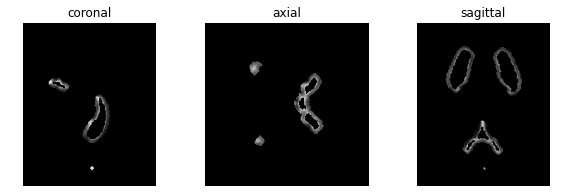

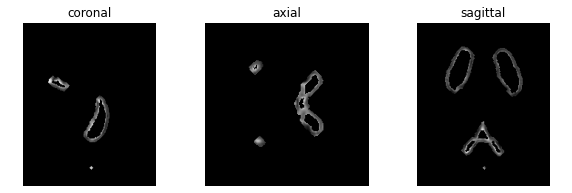

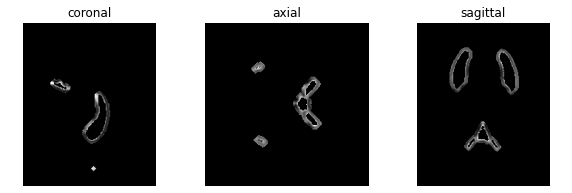

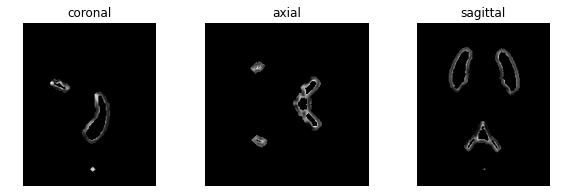

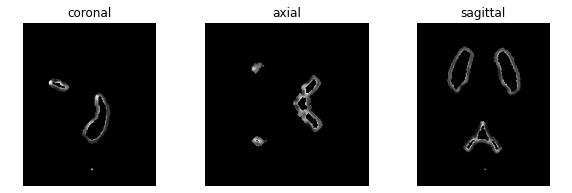

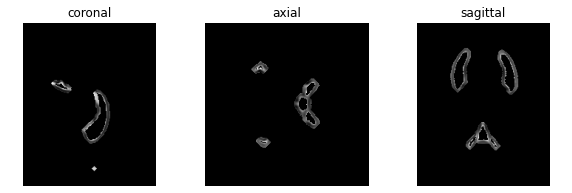

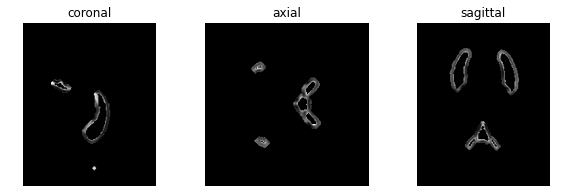

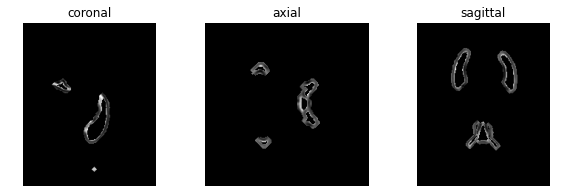

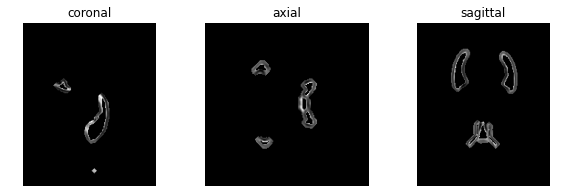

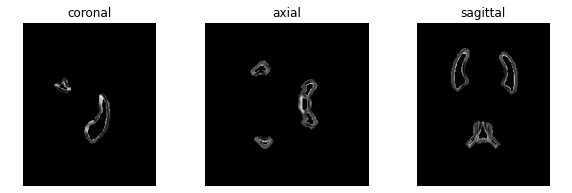

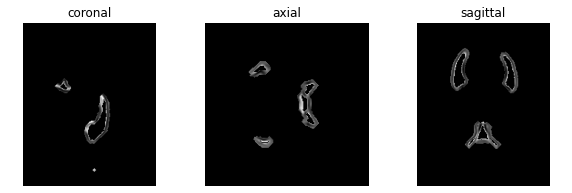

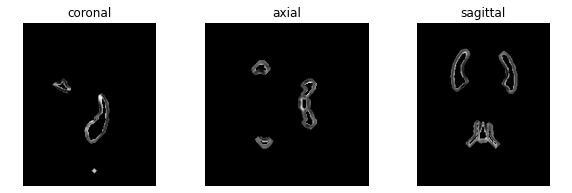

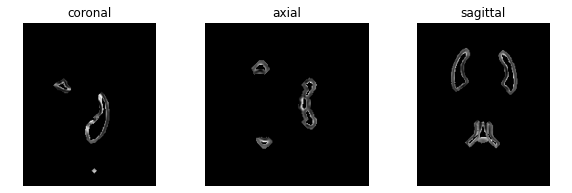

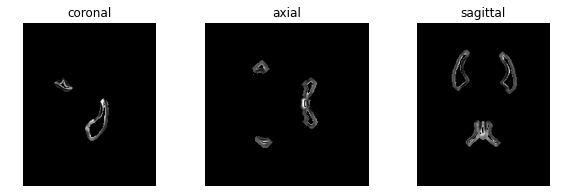

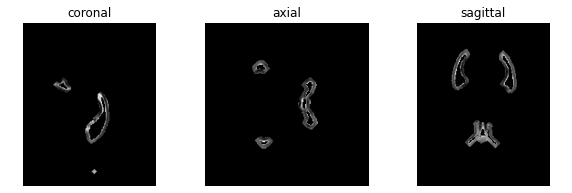

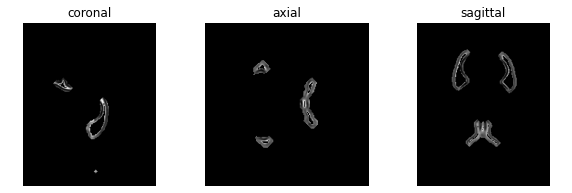

In [ ]:
# Initialise lists
volume_list = []
pix_intensity_list=[]

number_of_clusters = 3

# Loop over all atlas subjects
for subject in os.listdir(directory_atlas_image):
  # GA 
  GA = subject[1:3]
  print(GA + ' weeks')
  # Check if corresponding labels exist 
  dir_labels = 't'+GA+'_labels_FINAL-052022-split.nii.gz'
  if dir_labels in os.listdir(directory_atlas_labels):
    # Load images
    image = nib.load(directory_atlas_image+subject)
    # Convert to numpy array 
    image_data = image.get_fdata()
    # Load labels 
    labels = nib.load(directory_atlas_labels+dir_labels)
    # Convert to numpy array 
    labels_data = labels.get_fdata()

    # Perform k-means clustering with masked image
    kmeans_result,init_pos,image_masked = all_in_one(image_data, labels_data, GA, number_of_clusters) # calling function that returns the segmentation

    # Dilate masked image
    from scipy.ndimage import morphology # used for dilating
    dilated_mask = morphology.binary_dilation(image_masked,iterations=2) 
    dilated_image_data = np.multiply(dilated_mask,image_data)

    # Perform k-means clustering with dilated masked image
    kmeans_result,init_pos,image_masked = all_in_one(dilated_image_data, labels_data, GA, number_of_clusters) # calling function that returns the segmentation
 
    # Save dilated masked image 
    image_masked_filename = directory_dilated_masked_image + 't' + GA + '.00_mask.nii.gz' 
    image_masked_nii = nib.Nifti1Image(dilated_image_data, image.affine, image.header)
    nib.save(image_masked_nii,image_masked_filename)

    # Save k-means result for dilated masked image
    image_masked_filename = directory_dilated_masked_kmeans_results + 't' + GA + '.00_kmeans_labels.nii.gz' 
    image_masked_nii = nib.Nifti1Image(kmeans_result, image.affine, image.header)
    nib.save(image_masked_nii,image_masked_filename)

    # Initialise empty mask 
    image_masked = np.zeros(image_data.shape)
    # Extract desired label voxels 
    desired_voxels_index = np.where((labels_data != 0) & 
                                    (labels_data != 1) &
                                    (labels_data != 2) &
                                    (labels_data != 3) &
                                    (labels_data != 4) & #
                                    (labels_data != 5) & #
                                    (labels_data != 6) & #
                                    (labels_data != 10) &
                                    (labels_data != 11) &
                                    (labels_data != 12) &
                                    (labels_data != 13) &
                                    (labels_data != 14) &
                                    (labels_data != 15) &
                                    (labels_data != 16) &
                                    (labels_data != 17) &
                                    (labels_data != 18))
    # Get masked image 
    image_masked[desired_voxels_index] = image_data[desired_voxels_index]

    # Save mask
    image_masked_filename = directory_kmeans_mask + 't' + GA + '.00_mask.nii.gz' 
    # Save masked image as .nii.gz file
    image_masked_nii = nib.Nifti1Image(image_masked, image.affine, image.header)
    nib.save(image_masked_nii,image_masked_filename)


    # Dilate masked image
    from scipy.ndimage import morphology # used for dilating
    number_of_dilations = 4 #3
    number_of_erosions = 1 #1
    dilated_mask = morphology.binary_dilation(image_masked,iterations=number_of_dilations)
    eroded_mask = morphology.binary_erosion(image_masked,iterations=number_of_erosions)
    final_mask = np.zeros([image_masked.shape[0],image_masked.shape[1],image_masked.shape[2]])
    final_mask = np.multiply(dilated_mask,~eroded_mask)
    
    # Load k-means result 
    number_of_clusters = 3
    k_means_result = nib.load(directory_dilated_masked_kmeans_results+'t' + GA + '.00_kmeans_labels.nii.gz')
    k_means_result_data = k_means_result.get_fdata()

    # Multiply final masked image and k-means result
    dilated_image_data = np.multiply(final_mask,k_means_result_data)

    Display3D(np.multiply(final_mask,image_data))

    # Save masked k-means 
    image_masked_filename = directory_final_dilated_masked_kmeans_results + 't' + GA + '.00_kmeans_masked_labels.nii.gz' 
    # Save masked image as .nii.gz file
    image_masked_nii = nib.Nifti1Image(dilated_image_data, image.affine, image.header)
    nib.save(image_masked_nii,image_masked_filename)


    #Combine labels and save k-means segmentation 
    combined_seg = np.zeros(image_data.shape)
    dilated_image_data = np.round(dilated_image_data)
    combined_labels_ind = np.where(dilated_image_data == 1)
    combined_seg[combined_labels_ind] = 1

    desired_segmented_image = nib.Nifti1Image(combined_seg, image.affine, image.header)
    desired_segmented_image_filename = directory_final_dilated_masked_kmeans_results2 + 't' + GA + '.00_kmeans_masked_labels.nii.gz'  
    nib.save(desired_segmented_image,desired_segmented_image_filename)


K-Means Clustering for Subject Data

In [ ]:
csv_file = "new-fetal-files-for-manisha-072022/subject-ga.csv"
csv_data = pd.read_csv(csv_file,header=None)
csv_file_data = np.array(csv_data)
csv_subject_names = csv_file_data[:,0]
csv_subject_GA = csv_file_data[:,1]

parameters_file = "new-fetal-files-for-manisha-072022/Kmeans_parameters.xlsx"
parameters_data = pd.read_excel(parameters_file)
parameters_GA = np.array(parameters_data['GA'])
parameters_kclusters = np.array(parameters_data['k-clusters'])
parameters_mask1_dilation = np.array(parameters_data['mask-1-dilation'])
parameters_mask2_dilation = np.array(parameters_data['mask-2-dilation'])
parameters_mask2_erosion = np.array(parameters_data['mask-2-erosion'])

# Loop over all subjects
for subject in os.listdir(directory_subjects_image): 
  subject_filename = subject.rsplit('_',1)[0]
  print(subject_filename)
  # Find subject in csv file
  subject_filename_idx = np.where(csv_subject_names == subject_filename)
  GA_subject = csv_subject_GA[subject_filename_idx]
  # Round GA subject 
  GA = int(np.round(float(GA_subject)))
  
  if GA_subject > 36: # round down
    GA = 36
  print(GA_subject)
  
  # Load subject image
  image = nib.load(directory_subjects_image+subject)
  image_data = image.get_fdata()
  # Load subject labels
  labels = nib.load(directory_subjects_labels+subject_filename+'_rl_tissue.nii.gz')
  labels_data = labels.get_fdata()
  
  # Load parameters corresponding to atlas GA
  number_of_clusters = parameters_kclusters[np.where(parameters_GA == GA)][0]
  mask1_number_of_dilations = parameters_mask1_dilation[np.where(parameters_GA == GA)]
  mask2_number_of_dilations = parameters_mask2_dilation[np.where(parameters_GA == GA)]
  mask2_number_of_erosions = parameters_mask2_erosion[np.where(parameters_GA == GA)]

  number_of_clusters = 3
  mask1_number_of_dilations = 2
  mask2_number_of_dilations = 4
  mask2_number_of_erosions = 1
  
  # Perform k-means clustering with masked image
  kmeans_result,init_pos,image_masked = all_in_one(image_data, labels_data, GA, number_of_clusters) # calling function that returns the segmentation
  
  # Dilate masked image
  from scipy.ndimage import morphology # used for dilating
  dilated_mask = morphology.binary_dilation(image_masked,iterations=int(mask1_number_of_dilations))
  dilated_image_data = np.multiply(dilated_mask,image_data)

  # Perform k-means clustering with dilated masked image
  kmeans_result,init_pos,image_masked = all_in_one(dilated_image_data, labels_data, GA, number_of_clusters) # calling function that returns the segmentation

  # Save dilated masked image 
  image_masked_filename = directory_subject_dilated_masked_image + subject_filename + '_mask.nii.gz' 
  image_masked_nii = nib.Nifti1Image(dilated_image_data, image.affine, image.header)
  #nib.save(image_masked_nii,image_masked_filename) 

  # Save k-means result for dilated masked image
  image_masked_filename = directory_subject_dilated_masked_kmeans_results + subject_filename + '_kmeans_labels.nii.gz' 
  image_masked_nii = nib.Nifti1Image(kmeans_result, image.affine, image.header)
  #nib.save(image_masked_nii,image_masked_filename) 

  # Initialise empty mask 
  image_masked = np.zeros(image_data.shape)
  # Extract desired label voxels 
  desired_voxels_index = np.where((labels_data != 0) & 
                                  (labels_data != 1) &
                                  (labels_data != 2) &
                                  (labels_data != 3) &
                                  (labels_data != 4) & #
                                  (labels_data != 5) & #
                                  (labels_data != 6) & #
                                  #(labels_data != 7) &
                                  #(labels_data != 8) &
                                  #(labels_data != 9) &
                                  (labels_data != 10) &
                                  (labels_data != 11) &
                                  (labels_data != 12) &
                                  (labels_data != 13) &
                                  (labels_data != 14) &
                                  (labels_data != 15) &
                                  (labels_data != 16) &
                                  (labels_data != 17) &
                                  (labels_data != 18))
  
  # Get masked image 
  image_masked[desired_voxels_index] = image_data[desired_voxels_index]

  # Save mask
  image_masked_filename = directory_subject_kmeans_mask + subject_filename + '_mask.nii.gz'
  # Save masked image as .nii.gz file
  image_masked_nii = nib.Nifti1Image(image_masked, image.affine, image.header)
  #nib.save(image_masked_nii,image_masked_filename)

  # Dilate masked image
  from scipy.ndimage import morphology # used for dilating
  number_of_dilations = 4
  number_of_erosions = 1

  dilated_mask = morphology.binary_dilation(image_masked,iterations=int(number_of_dilations))
  eroded_mask = morphology.binary_erosion(image_masked,iterations=int(number_of_erosions))
  final_mask = np.zeros([image_masked.shape[0],image_masked.shape[1],image_masked.shape[2]])
  final_mask = np.multiply(dilated_mask,~eroded_mask)

  # Load k-means result 
  k_means_result = nib.load(directory_subject_dilated_masked_kmeans_results + subject_filename + '_kmeans_labels.nii.gz')
  k_means_result_data = k_means_result.get_fdata()

  # Multiply final masked image and k-means result
  dilated_image_data = np.multiply(final_mask,k_means_result_data)

  # Save masked k-means 
  image_masked_filename = directory_subject_final_dilated_masked_kmeans_results  + subject_filename + '_kmeans_masked_labels.nii.gz' 
  # Save masked image as .nii.gz file
  image_masked_nii = nib.Nifti1Image(dilated_image_data, image.affine, image.header)
  nib.save(image_masked_nii,image_masked_filename)

  # Combine labels and save k-means segmentation 
  combined_seg = np.zeros(image_data.shape)
  combined_seg2 = np.zeros(image_data.shape)
  combined_seg3 = np.zeros(image_data.shape)
  combined_seg4 = np.zeros(image_data.shape)

  dilated_image_data = np.round(dilated_image_data)
  combined_labels_ind = np.where(dilated_image_data == 1)
  combined_seg[combined_labels_ind] = 1

  combined_labels_ind2 = np.where(dilated_image_data == 2)
  combined_seg2[combined_labels_ind2] = 1

  combined_labels_ind3 = np.where(dilated_image_data == 3)
  combined_seg3[combined_labels_ind3] = 1

  # Calculate intensity
  number_of_vox_in_label = np.count_nonzero(combined_seg)
  label_values = image_data[combined_labels_ind]
  average_intensities_ventricular_zone = sum(label_values)/number_of_vox_in_label

  number_of_vox_in_label2 = np.count_nonzero(combined_seg2)
  label_values2 = image_data[combined_labels_ind2]
  average_intensities_ventricular_zone2 = sum(label_values2)/number_of_vox_in_label2

  number_of_vox_in_label3 = np.count_nonzero(combined_seg3)
  label_values3 = image_data[combined_labels_ind3]
  average_intensities_ventricular_zone3 = sum(label_values3)/number_of_vox_in_label3

  # Determine label with min intensity 
  average_intensities = [average_intensities_ventricular_zone,average_intensities_ventricular_zone2,average_intensities_ventricular_zone3]
  idx_min_intensity = average_intensities.index(min(average_intensities)) + 1
  
  if idx_min_intensity == 1:
    desired_segmented_image = nib.Nifti1Image(combined_seg, image.affine, image.header)
  elif idx_min_intensity == 2:
    desired_segmented_image = nib.Nifti1Image(combined_seg2, image.affine, image.header)
  elif idx_min_intensity == 3:
    desired_segmented_image = nib.Nifti1Image(combined_seg3, image.affine, image.header)
  elif subject_filename == 'sub-CC01024XX10_ses-48731':
    combined_labels_ind4 = np.where((dilated_image_data == 1) | (dilated_image_data == 2))
    combined_labels_ind4 = np.where(dilated_image_data == 1)
    combined_seg4[combined_labels_ind4] = 1
    desired_segmented_image = nib.Nifti1Image(combined_seg4, image.affine, image.header)

  desired_segmented_image_filename = directory_subject_final_dilated_masked_kmeans_results2 + subject_filename + '_kmeans_masked_labels.nii.gz' 
  nib.save(desired_segmented_image,desired_segmented_image_filename)



sub-CC00866XX17_ses-1820
[32.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00856XX15_ses-3530
[37.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00870XX13_ses-4421
[31.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00861XX12_ses-43210
[28.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00905XX14_ses-7231
[29.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00921XX14_ses-10932
[30.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00873XX16_ses-41610
[24.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00932XX17_ses-14730
[28.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00882XX17_ses-731
[34.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00874XX17_ses-42510
[30.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00926XX19_ses-14030
[32.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00896XX23_ses-4831
[32.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00879XX22_ses-1020
[36.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00929XX22_ses-16430
[31.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00877XX20_ses-820
[26.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00878XX21_ses-3531
[29.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00883XX18_ses-1821
[34.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00901XX10_ses-4830
[28.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00906XX15_ses-10931
[31.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00903XX12_ses-2630
[35.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00897XX24_ses-6230
[30.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00915XX16_ses-10031
[35.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00909XX18_ses-16731
[29.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00892XX19_ses-1630
[34.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00934XX19_ses-23131
[33.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00917XX18_ses-7230
[27.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00886XX21_ses-3520
[29.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00918XX19_ses-14031
[28.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00911XX12_ses-5130
[33.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00904XX13_ses-3930
[28.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00902XX11_ses-6831
[27.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00908XX17_ses-14732
[31.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00941XX18_ses-17731
[29.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00944XX21_ses-21931
[33.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00992XX20_ses-36831
[27.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00950XX10_ses-24030
[29.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00967XX19_ses-27130
[26.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00949XX26_ses-21930
[25.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00991XX19_ses-58531
[35.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00937XX22_ses-16732
[34.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00968XX20_ses-24431
[32.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00947XX24_ses-22331
[33.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00988XX24_ses-35231
[29.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00982XX18_ses-55730
[36.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00965XX17_ses-21231
[33.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00993XX21_ses-36830
[25.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00973XX17_ses-29930
[25.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00962XX14_ses-26230
[27.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00969XX21_ses-25531
[22.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00966XX18_ses-24430
[32.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00953XX13_ses-18731
[30.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00938XX23_ses-19830
[26.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00940XX17_ses-17730
[30.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00980XX16_ses-28430
[23.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00991XX19_ses-35230
[23.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00951XX11_ses-23831
[34.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00990XX18_ses-53230
[32.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00957XX17_ses-19931
[31.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00995XX23_ses-37330
[31.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00961XX13_ses-23830
[33.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00958XX18_ses-20731
[34.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01024XX10_ses-48731
[24.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01043XX13_ses-53232
[32.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01022XX08_ses-46730
[21.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01001XX03_ses-39230
[25.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01054XX07_ses-63530
[34.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01037XX15_ses-54231
[25.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01013XX07_ses-42731
[24.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01000XX02_ses-38831
[25.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01031XX09_ses-54930
[23.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01042XX12_ses-60730
[33.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01019XX13_ses-67731
[33.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01016XX10_ses-45330
[27.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01013XX07_ses-61531
[35.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01017XX11_ses-45331
[32.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01001XX03_ses-57230
[35.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01026XX12_ses-56830
[27.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01053XX06_ses-59231
[36.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01061XX06_ses-74331
[31.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01010XX04_ses-54430
[28.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01041XX11_ses-60030
[28.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01020XX06_ses-59631
[28.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00996XX24_ses-57230
[33.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01019XX13_ses-56831
[26.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01035XX13_ses-52030
[27.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00999XX27_ses-38031
[25.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC00996XX24_ses-38032
[23.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01051XX04_ses-67230
[31.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01055XX08_ses-62130
[32.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01016XX10_ses-62431
[37.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01103XX06_ses-82130
[31.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01112XX07_ses-94730
[32.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01090XX11_ses-71830
[36.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01107XX10_ses-82730
[34.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01113XX08_ses-84630
[35.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01087XX16_ses-86231
[33.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01089XX18_ses-72630
[26.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01069XX14_ses-65430
[31.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01112XX07_ses-81730
[24.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01070XX07_ses-66131
[28.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01068XX13_ses-66830
[27.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01076XX13_ses-64532
[25.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01099XX20_ses-82431
[31.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01121XX08_ses-97930
[30.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01120XX07_ses-91430
[24.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01109XX12_ses-88131
[24.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01073XX10_ses-69431
[31.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01110XX05_ses-83430
[24.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01106XX09_ses-86230
[24.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01105XX08_ses-81330
[32.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01065XX10_ses-67730
[27.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01114XX09_ses-82430
[26.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01075XX12_ses-69730
[27.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01115XX10_ses-94430
[30.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01115XX10_ses-87031
[25.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01070XX07_ses-74330
[34.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01085XX14_ses-71230
[34.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01071XX08_ses-66130
[37.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01147XX18_ses-101330
[26.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01137XX16_ses-93632
[31.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01134XX13_ses-93631
[26.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01172XX10_ses-111630
[29.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01127XX14_ses-88930
[27.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01179XX17_ses-113330
[28.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01155XX09_ses-102330
[27.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01143XX14_ses-100230
[32.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01157XX11_ses-104630
[22.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01170XX08_ses-108031
[36.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01173XX11_ses-113930
[28.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01160XX06_ses-109530
[36.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01165XX11_ses-105931
[24.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01168XX14_ses-107630
[29.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01146XX17_ses-99130
[25.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01138XX17_ses-95030
[25.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01129XX16_ses-91530
[27.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01158XX12_ses-103830
[22.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01156XX10_ses-105932
[28.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01171XX09_ses-110231
[25.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01132XX11_ses-97730
[33.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01182XX12_ses-114431
[30.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01126XX13_ses-90530
[24.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01144XX15_ses-98730
[22.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01125XX12_ses-89430
[27.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01148XX19_ses-99930
[35.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01140XX11_ses-115230
[35.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01150XX04_ses-108030
[31.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01128XX15_ses-105933
[34.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01226XX14_ses-150730
[28.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01221XX09_ses-148830
[31.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01186XX16_ses-126230
[31.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01188XX18_ses-125930
[31.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01185XX15_ses-121930
[28.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01227XX15_ses-151731
[30.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01184XX14_ses-123530
[32.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01253XX08_ses-168830
[32.0]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01217XX13_ses-147630
[25.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01235XX15_ses-155530
[28.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01243XX15_ses-163830
[29.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01197XX19_ses-141031
[29.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01195XX17_ses-138530
[28.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01200XX04_ses-141530
[29.43]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01194XX16_ses-133130
[29.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01237XX17_ses-155730
[33.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01240XX12_ses-162131
[26.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01230XX10_ses-154830
[33.86]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01239XX19_ses-160530
[36.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01213XX09_ses-146230
[28.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01189XX19_ses-127030
[33.29]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01263XX10_ses-171930
[24.71]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01187XX17_ses-124930
[30.14]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


sub-CC01249XX21_ses-165630
[27.57]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [ ]:
# Loop over all subjects
for subject in os.listdir(directory_subjects_image): 
  subject_filename = subject.rsplit('_',1)[0]
  print(subject_filename)
  if subject_filename == 'sub-CC01024XX10_ses-48731':
  
    # Load subject labels
    k_means_result = nib.load(directory_subject_final_dilated_masked_kmeans_results  + subject_filename + '_kmeans_masked_labels.nii.gz' )
    dilated_image_data = k_means_result.get_fdata()

    # Combine labels and save k-means segmentation 
    combined_seg = np.zeros(image_data.shape)

    dilated_image_data = np.round(dilated_image_data)
    combined_labels_ind = np.where((dilated_image_data == 1) | (dilated_image_data == 2))
    combined_seg[combined_labels_ind] = 1

    desired_segmented_image = nib.Nifti1Image(combined_seg, image.affine, image.header)
    desired_segmented_image_filename = directory_subject_final_dilated_masked_kmeans_results2 + subject_filename + '_kmeans_masked_labels.nii.gz' 
    nib.save(desired_segmented_image,desired_segmented_image_filename)



sub-CC00866XX17_ses-1820
sub-CC00856XX15_ses-3530
sub-CC00870XX13_ses-4421
sub-CC00861XX12_ses-43210
sub-CC00905XX14_ses-7231
sub-CC00921XX14_ses-10932
sub-CC00873XX16_ses-41610
sub-CC00932XX17_ses-14730
sub-CC00882XX17_ses-731
sub-CC00874XX17_ses-42510
sub-CC00926XX19_ses-14030
sub-CC00896XX23_ses-4831
sub-CC00879XX22_ses-1020
sub-CC00929XX22_ses-16430
sub-CC00877XX20_ses-820
sub-CC00878XX21_ses-3531
sub-CC00883XX18_ses-1821
sub-CC00901XX10_ses-4830
sub-CC00906XX15_ses-10931
sub-CC00903XX12_ses-2630
sub-CC00897XX24_ses-6230
sub-CC00915XX16_ses-10031
sub-CC00909XX18_ses-16731
sub-CC00892XX19_ses-1630
sub-CC00934XX19_ses-23131
sub-CC00917XX18_ses-7230
sub-CC00886XX21_ses-3520
sub-CC00918XX19_ses-14031
sub-CC00911XX12_ses-5130
sub-CC00904XX13_ses-3930
sub-CC00902XX11_ses-6831
sub-CC00908XX17_ses-14732
sub-CC00941XX18_ses-17731
sub-CC00944XX21_ses-21931
sub-CC00992XX20_ses-36831
sub-CC00950XX10_ses-24030
sub-CC00967XX19_ses-27130
sub-CC00949XX26_ses-21930
sub-CC00991XX19_ses-58531
sub-CC0


-----------

Label Propagation using Subject Data

In [ ]:
# Install ants
!pip install antspyx
# Import ants
import ants

# Install SimpleITK 
!pip install SimpleITK
# Import sitk
import SimpleITK as sitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 319.4 MB 25 kB/s 
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=c59819b712710fe7f3e70c4dc776485db98c3d589130003e8242970263d2a9e8
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.2 MB/s 


In [ ]:
# Directories 
directory_atlas_image = 'new-fetal-files-for-manisha-072022/atlas_t2/'
directory_atlas_labels = 'new-fetal-files-for-manisha-072022/atlases_kclusters_3/atlas_masked_kmeans_results_combined/'
directory_subjects_image = 'new-fetal-files-for-manisha-072022/subjects_t2/'
directory_subjects_labels = 'new-fetal-files-for-manisha-072022/subjects_segmentations/'
directory_propagated_subjects_labels = 'new-fetal-files-for-manisha-072022/subjects_propagated_segmentations/'

In [ ]:
# Define function for label propagation 
def label_propagation(ants_template,ants_template_labels,ants_image):

    # Check to see image and template are not aligned
    ants.plot(ants_image, ants_template, axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3, title="Image and template not aligned")

    # Perform affine registration of template to image
    t_affine = ants.registration( fixed=ants_image, moving=ants_template,type_of_transform='Affine' )

    # Transform template 
    ants_template_affine = ants.apply_transforms( fixed=ants_image, moving=ants_template, interpolator='linear',transformlist=t_affine['fwdtransforms'])

    # Check alignment
    ants.plot(ants_image, ants_template_affine,axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3, title="Affine alignment")


    # Perform non-linear registration initialised with affine
    t_nonlinear = ants.registration( fixed=ants_image, moving=ants_template,
                                initial_transform = t_affine['fwdtransforms'][0],
                                reg_iterations = [40,20,0], # lower quality 
                                #reg_iterations = [40,40,40], # higher quality 
                                type_of_transform='SyNOnly')
    
    ants_template_nonlinear = ants.apply_transforms( fixed=ants_image, moving=ants_template, interpolator='linear',transformlist=t_nonlinear['fwdtransforms'] )

    # Check alignment 
    ants.plot(ants_image, ants_template_nonlinear,axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3,title="Nonlinear alignment")

    # Propagate labels
    propagated_labels = ants.apply_transforms( fixed=ants_image, moving=ants_template_labels, #domain_image=fixed_image,
                                                interpolator='nearestNeighbor', transformlist=t_nonlinear['fwdtransforms'] )
    
    # Plot propagated labels overlayed on the image
    ants.plot(ants_image, propagated_labels,axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.5, title="Propagated labels")
    
    return propagated_labels

In [ ]:
csv_file = "new-fetal-files-for-manisha-072022/subject-ga.csv"
csv_data = pd.read_csv(csv_file,header=None)
csv_file_data = np.array(csv_data)
csv_subject_names = csv_file_data[:,0]
csv_subject_GA = csv_file_data[:,1]

# Loop over all subjects
for subject in os.listdir(directory_subjects_image)[2:20]: 
  subject_filename = subject.rsplit('_',1)[0]
  print(subject_filename)
  # Find subject in csv file
  subject_filename_idx = np.where(csv_subject_names == subject_filename)
  GA_subject = csv_subject_GA[subject_filename_idx][0]
  # Round GA subject 
  GA = int(np.round(float(GA_subject)))
  
  if GA_subject > 36: # round down
    GA = 36
  print(GA)
  print(GA_subject)
  
  # Read data in ants format 
  ants_atlas_image = ants.image_read(directory_atlas_image+'t'+ str(GA) + '.00.nii.gz')
  ants_atlas_labels = ants.image_read(directory_atlas_labels+'t'+str(GA)+ '.00_kmeans_masked_labels.nii.gz')
  ants_subject_image = ants.image_read(directory_subjects_image+subject_filename+'_t2.nii.gz')
  image = nib.load(directory_subjects_image+subject_filename+'_t2.nii.gz')

  # Label propagation 
  ants_subject_propagated_labels = label_propagation(ants_atlas_image,ants_atlas_labels,ants_subject_image)

  # Save propagated labels
  np_subject_propagated_labels = ants_subject_propagated_labels.numpy()
  subject_propagated_labels_filename = directory_propagated_subjects_labels + subject_filename + '_propagated_labels_lower_quality.nii.gz'
  subject_propagated_labels_nii = nib.Nifti1Image(np_subject_propagated_labels, image.affine, image.header)
  nib.save(subject_propagated_labels_nii,subject_propagated_labels_filename)

Output hidden; open in https://colab.research.google.com to view.